## Setup

In [ ]:
!pip install keras-tuner

In [ ]:
import os
import shutil

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## 1. Downloading Dataset from Kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/kaggle.json ~/.kaggle/

cp: cannot stat '/content/kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download tourist55/alzheimers-dataset-4-class-of-images

Dataset URL: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images
License(s): ODbL-1.0
 50% 17.0M/34.1M [00:00<00:00, 32.7MB/s]
100% 34.1M/34.1M [00:00<00:00, 55.3MB/s]


In [ ]:
!unzip alzheimers-dataset-4-class-of-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem207.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem208.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem209.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem21.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem210.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem211.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem212.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem213.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem214.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem215.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem216.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem217.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/mildDem218.jpg  
  inflating: Alzheimer_s Dataset/train/MildDemented/m

## 2. Fixing Folder Structure

In [ ]:
def merge_subfolders(data_folder):
    #data_folder = 'Alzheimer_s Dataset/train'
    subfolders = ['MildDemented', 'ModerateDemented', 'VeryMildDemented']
    destination_folder = 'AllDemented'

    destination_path = os.path.join(data_folder, destination_folder)
    os.makedirs(destination_path, exist_ok=True)

    for subfolder in subfolders:
        subfolder_path = os.path.join(data_folder, subfolder)

        for filename in os.listdir(subfolder_path):
            #new file names subfolder_originalname
            new_filename = f"{subfolder}_{filename}"

            src = os.path.join(subfolder_path, filename)
            dst = os.path.join(destination_path, new_filename)

            shutil.copy(src, dst)

    print("Done")
    return

In [ ]:
#paths for dataset
alzheimer_train = "Alzheimer_s Dataset/train"
alzheimer_test = "Alzheimer_s Dataset/test"

merge_subfolders(alzheimer_train)
merge_subfolders(alzheimer_test)

Done
Done


In [ ]:
def delete_other_folders(directory, keep_folders):
    """
    Delete all folders in the specified directory except the ones listed in keep_folders.

    Parameters:
    - directory: str, the path to the main directory.
    - keep_folders: list of str, the names of the folders to keep.
    """
    for folder_name in os.listdir(directory):
        folder_path = os.path.join(directory, folder_name)
        if os.path.isdir(folder_path) and folder_name not in keep_folders:
            print(f"Deleting folder: {folder_path}")
            shutil.rmtree(folder_path)
    return

In [ ]:
# Define the folders to keep
keep_folders = ['AllDemented', 'NonDemented']

# Delete other folders in the train and test directories
delete_other_folders(alzheimer_train, keep_folders)
delete_other_folders(alzheimer_test, keep_folders)

print("Completed deletion of other folders.")

Deleting folder: Alzheimer_s Dataset/train/MildDemented
Deleting folder: Alzheimer_s Dataset/train/ModerateDemented
Deleting folder: Alzheimer_s Dataset/train/VeryMildDemented
Deleting folder: Alzheimer_s Dataset/test/MildDemented
Deleting folder: Alzheimer_s Dataset/test/ModerateDemented
Deleting folder: Alzheimer_s Dataset/test/VeryMildDemented
Completed deletion of other folders.


## 3. Load and Visualize the Data

In [ ]:
# Fixed parameters.
train_dir = "Alzheimer_s Dataset/train"
test_dir = "Alzheimer_s Dataset/test"

batch_size = 32
img_height = 208
img_width = 176
num_classes = 2

### 3.1 Create a Dataset

In [ ]:
# Instantiate Datasets.
train_validate_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    subset="both",
    validation_split=0.2,
    seed = 123,
    label_mode="binary"
)

test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed = 123,
    label_mode="binary"
)

train_ds = train_validate_ds[0]
validation_ds = train_validate_ds[1]

Found 5121 files belonging to 2 classes.
Using 4097 files for training.
Using 1024 files for validation.
Found 1279 files belonging to 2 classes.


### 3.2 Visualize the Data

<ipython-input-18-f4c0dc32860d>:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(labels[i].numpy())


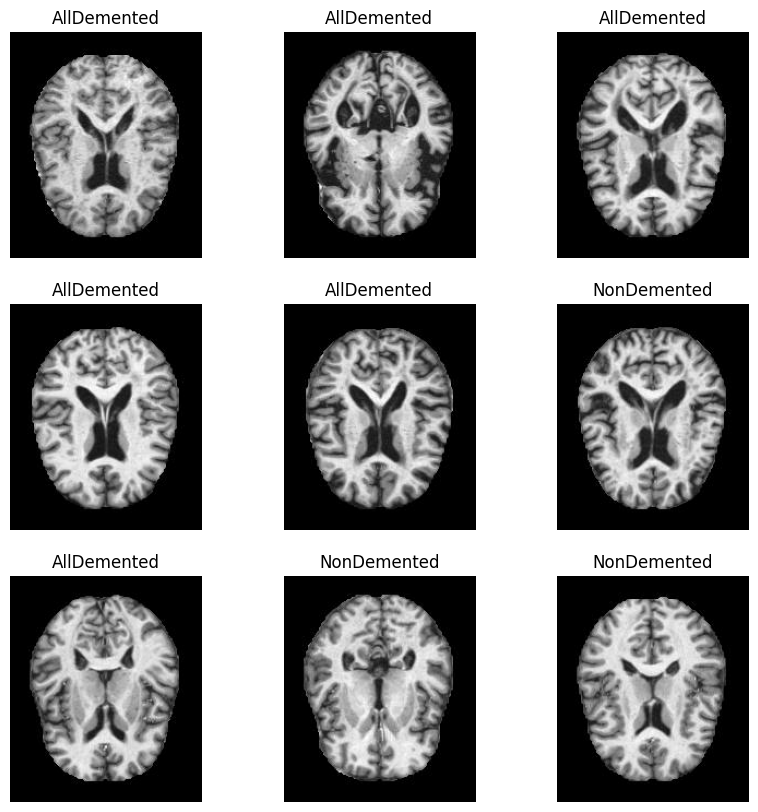

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = int(labels[i].numpy())
    plt.title(class_names[label_index])
    plt.axis("off")

## 4. Final Model with Data Augmentation and Dropout

### 4.1 Data Augmentation

#### 4.1.1 Implementing Data Augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from our existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside our model like other layers.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
  ]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### 4.1.2 Visualize Augmented Examples.

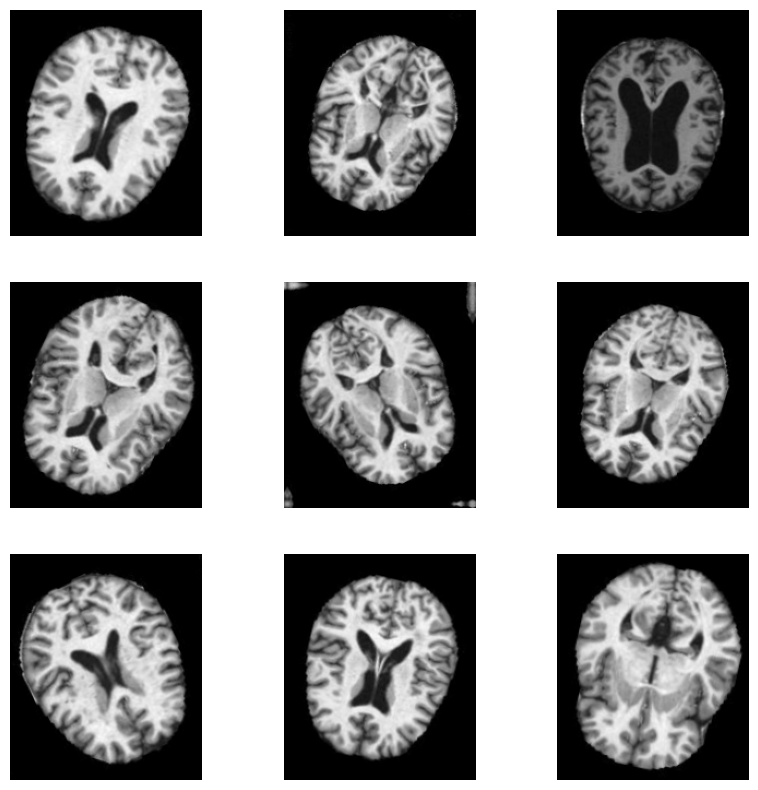

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].numpy().astype("uint8"))
    plt.axis("off")

### 4.2 Create the Model

Create a normal `Sequential` CNN, but with the following adjustments:

1. Augment the data before the input layer.
2. Standardize the data after augmentation.
3. Add a Dropout layer in the model.

In [ ]:
model = Sequential([
   data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(64, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Conv2D(128, (3, 3), activation='relu'),
  layers.MaxPooling2D((2, 2)),
  layers.Flatten(),
  layers.Dropout(0.5),
  layers.Dense(512, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

### 4.3 Compile and Train the Model

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 208, 176, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=100
)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.5244 - loss: 0.7187 - val_accuracy: 0.4834 - val_loss: 0.7412
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.5210 - loss: 0.6940 - val_accuracy: 0.6426 - val_loss: 0.6344
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.5885 - loss: 0.6722 - val_accuracy: 0.6846 - val_loss: 0.6004
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.6641 - loss: 0.6234 - val_accuracy: 0.6611 - val_loss: 0.5978
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.6662 - loss: 0.6118 - val_accuracy: 0.6777 - val_loss: 0.5871
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - accuracy: 0.6821 - loss: 0.5971 - val_accuracy: 0.6826 - val_loss: 0.5873
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6994 - loss: 0.5819 - val_accuracy: 0.7002 - val_loss: 0.5627
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6899 - loss: 0.5767

### 4.4 Visualize Training Results

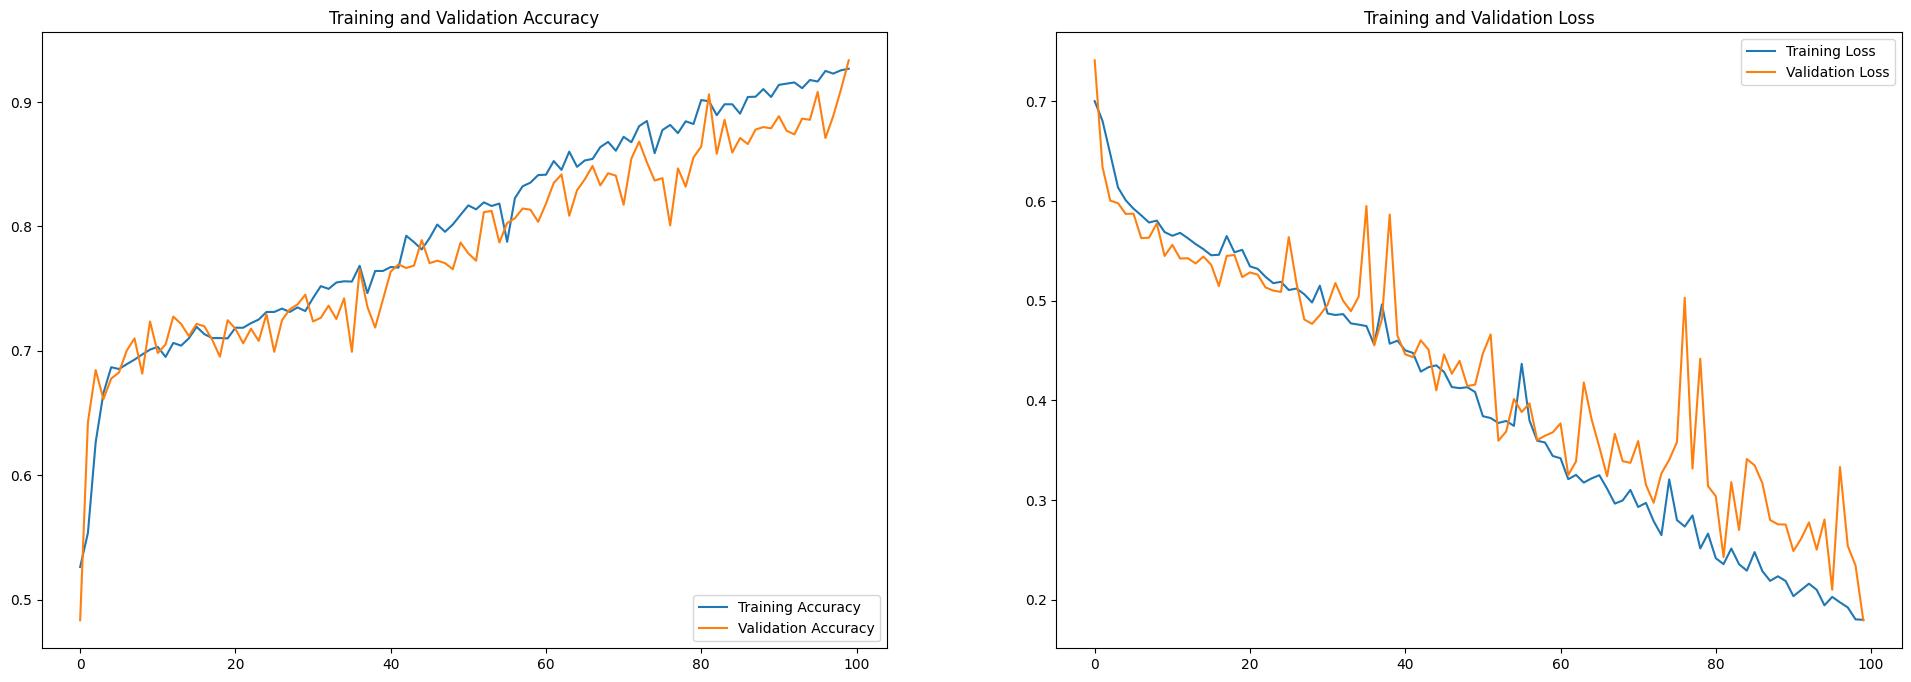

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 4.5 Evaluate the Model

              precision    recall  f1-score   support

 AllDemented       0.72      0.82      0.77       639
 NonDemented       0.79      0.69      0.74       640

    accuracy                           0.75      1279
   macro avg       0.76      0.75      0.75      1279
weighted avg       0.76      0.75      0.75      1279



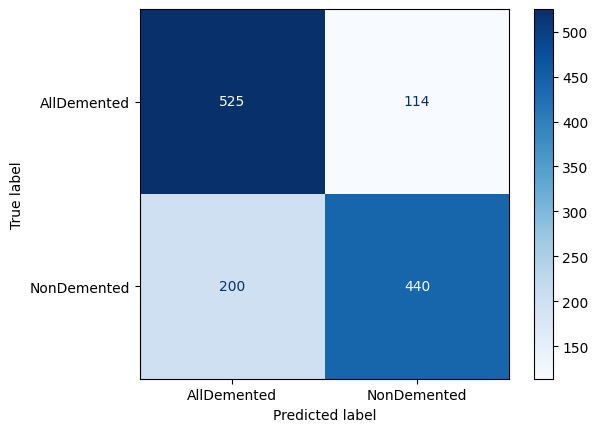

In [ ]:
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for images, labels in test_ds:
  true_labels.extend(labels.numpy())
  predicted_labels.extend((model.predict(images, verbose=0) > 0.5).astype("int32"))

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## 5. Hyperparameter Tuning

### 5.1 Define HyperModel

In [ ]:
# Define the hypermodel
def build_model(hp):
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), activation=hp.Choice('conv_activation', values=['relu', 'tanh', 'sigmoid'])),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=hp.Choice('conv_activation', values=['relu', 'tanh', 'sigmoid'])),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=hp.Choice('conv_activation', values=['relu', 'tanh', 'sigmoid'])),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=hp.Choice('conv_activation', values=['relu', 'tanh', 'sigmoid'])),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'])),
        layers.Dense(1, activation='sigmoid')
    ])

    # Choose the optimizer
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])

    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

### 5.2 Instantiate Tuner

In [ ]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Adjust the number of trials based on your needs
    executions_per_trial=1,
    directory='my_dir',
    project_name='hyperparam_tuning'
)

### 5.3 Run the Tuning

In [ ]:
# Run the hyperparameter search
tuner.search(train_ds,
             validation_data=validation_ds,
             epochs=10,  # Adjust the number of epochs
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3)])

# Get the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate is {best_hps.get('learning_rate')},
the optimal optimizer is {best_hps.get('optimizer')}, and the optimal activation functions are
{best_hps.get('conv_activation')} for conv layers and {best_hps.get('dense_activation')} for dense layers.
""")

Trial 10 Complete [00h 01m 09s]
val_accuracy: 0.5166015625

Best val_accuracy So Far: 0.7119140625
Total elapsed time: 00h 11m 55s

The hyperparameter search is complete. The optimal learning rate is 0.0001, 
the optimal optimizer is adam, and the optimal activation functions are 
tanh for conv layers and relu for dense layers.



/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### 5.4 Train Model with Optimal Hyperparameters

In [ ]:
def build_best_model(hp):
    model = Sequential([
        data_augmentation,
        layers.Rescaling(1./255),
        layers.Conv2D(32, (3, 3), activation=hp.get('conv_activation')),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation=hp.get('conv_activation')),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=hp.get('conv_activation')),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation=hp.get('conv_activation')),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation=hp.get('dense_activation')),
        layers.Dense(1, activation='sigmoid')
    ])

    if hp.get('optimizer') == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=hp.get('learning_rate'))
    elif hp.get('optimizer') == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=hp.get('learning_rate'))
    elif hp.get('optimizer') == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=hp.get('learning_rate'))

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Build the model with the best hyperparameters
best_model = build_best_model(best_hps)

In [ ]:
# Train the model for 100 epochs
history = best_model.fit(train_ds,
                         validation_data=validation_ds,
                         epochs=100)

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 50ms/step - accuracy: 0.5553 - loss: 0.6810 - val_accuracy: 0.6973 - val_loss: 0.5846
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6287 - loss: 0.6403 - val_accuracy: 0.6396 - val_loss: 0.6562
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.6978 - loss: 0.5799 - val_accuracy: 0.6797 - val_loss: 0.6115
Epoch 4/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - accuracy: 0.6849 - loss: 0.5852 - val_accuracy: 0.7109 - val_loss: 0.5812
Epoch 5/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7054 - loss: 0.5750 - val_accuracy: 0.6729 - val_loss: 0.5928
Epoch 6/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6974 - loss: 0.5802 - val_accuracy: 0.5664 - val_loss: 0.7620
Epoch 7/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6256 - loss: 0.6504 - val_accuracy: 0.7139 - val_loss: 0.5566
Epoch 8/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7116 - loss: 0.564

### 5.5 Visualizing Results

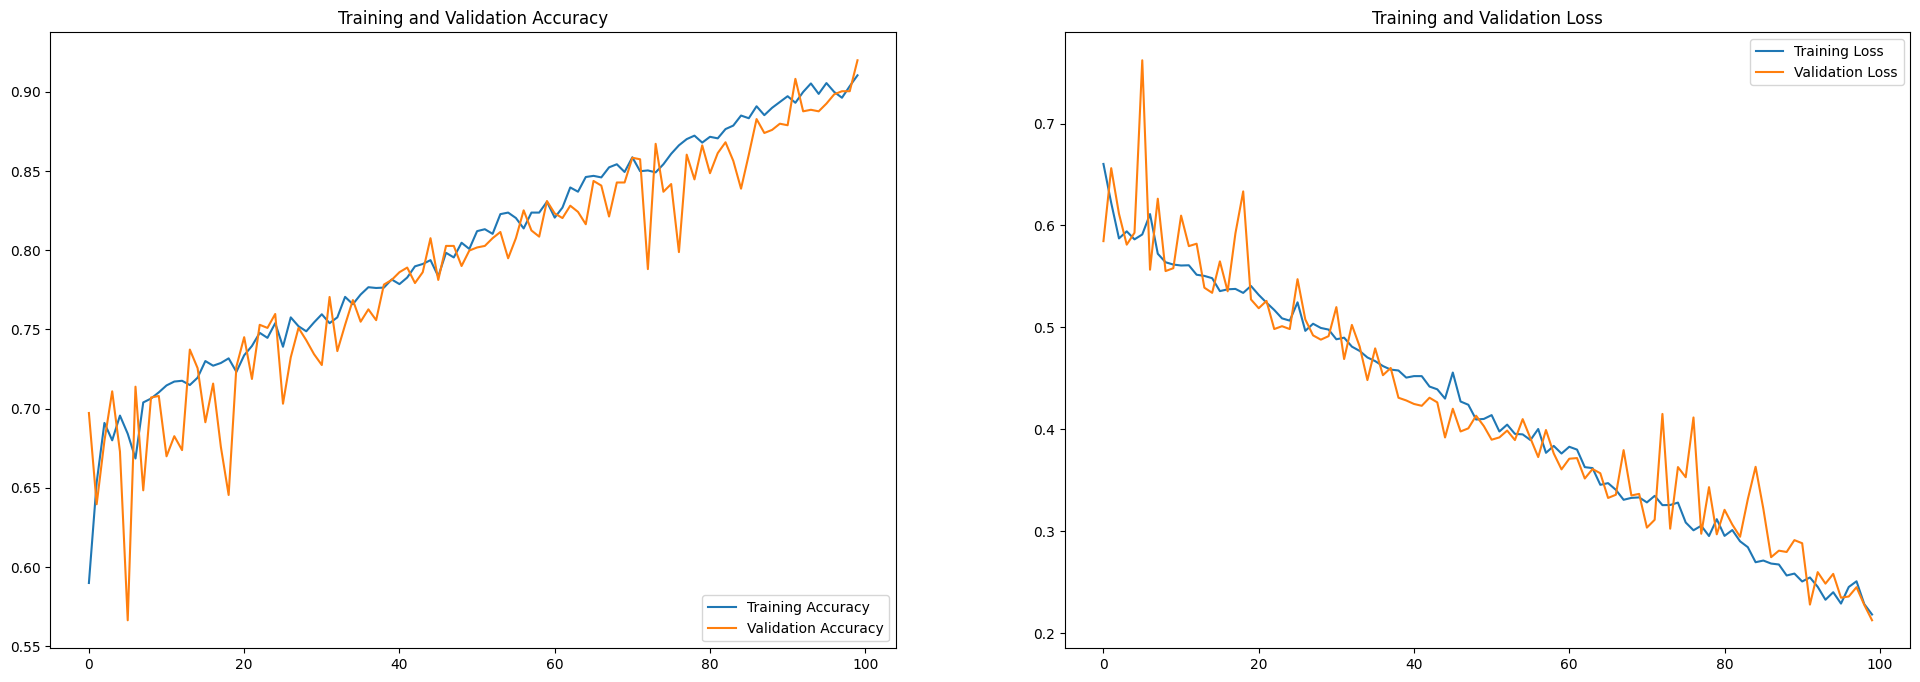

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

              precision    recall  f1-score   support

 AllDemented       0.58      0.98      0.73       639
 NonDemented       0.93      0.29      0.44       640

    accuracy                           0.63      1279
   macro avg       0.75      0.63      0.58      1279
weighted avg       0.75      0.63      0.58      1279



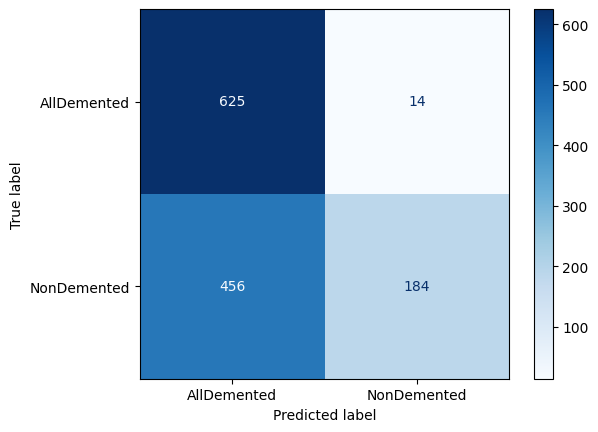

In [ ]:
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for images, labels in test_ds:
  true_labels.extend(labels.numpy())
  predicted_labels.extend((best_model.predict(images, verbose=0) > 0.5).astype("int32"))

report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.show()